# Label Randomization experiment

This notebook shows what happens as the fraction of randomized labels increases from 0% to 95%. To test this, we will train a simple Multi-Layer Perceptron (MLP) on the CIFAR10 dataset, with an increasing fraction of random labels.

It turns out that as the % of randomized training labels increases up to about 45%,
 - Training accuracy declines. (This experimental setup guarantees this by randomizing the labels *every time the example is used in training*, not just once.) 
 - The weight matrix eigenspectra also remain relatively stable.
 - the test accuracy declines by quite a bit less than the training accuracy does. 

Then, however, at a certain point a "phase transition" occurs, meaning that the eigenspectrum starts to shift -- it looks more like that of a random matrix. Concurrently with this, test accuracy will *also* begin to decline, as predicted by the Implicit Self Regularization theory.

We can also do a similar experiment where we randomize the *features* rather than the labels, and the outcome is the same.

For context we are showing the "easy case" from [this blog post](https://calculatedcontent.com/2018/04/01/rethinking-or-remembering-generalization-in-neural-networks/).

In [2]:
import numpy as np
import PIL

from torch.utils.data import DataLoader, Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import PILToTensor

from weightwatcher.RMT_Util import permute_matrix
class RNDDataSet(Subset):
    def __init__(self, train, p, randomize_labels=False, randomize_features=False):
        assert isinstance(train, bool), type(train)
        assert isinstance(randomize_labels, bool), type(randomize_labels)
        assert isinstance(randomize_features, bool), type(randomize_features)
        self.DS = CIFAR10("datasets", train=train, download=True)
        self.p2t = PILToTensor()
        self.p = p
        self.randomize_labels = randomize_labels
        self.randomize_features = randomize_features
    
    def __len__(self):
        return len(self.DS)
    
    def __getitem__(self, item):
        d, l = self.DS[item]
        d = self.p2t(d)
        
        #Randomize every time, not just once, so that the model doesn't "learn" some sampling artifact.
        if self.randomize_labels and np.random.random() < self.p:
            l = int(np.random.random()*10)
            
        if self.randomize_features and np.random.random() < self.p:
            d = permute_matrix(d.numpy())
            
        return (d.to(torch.float32)/255, l)

In [3]:
from pathlib import Path

import torch
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self):
        from torch.nn import Flatten, Linear, ReLU, Sequential
        super(MLP, self).__init__()
        
        self.op = Sequential(
            Flatten(),
            Linear(32*32*3, 512, bias=True), ReLU(),
            Linear(512, 512, bias=True), ReLU(),
            Linear(512, 512, bias=True), ReLU(),
            Linear(512, 10, bias=True)
        )
    
    def forward(self, x):
        return F.softmax(self.op(x))
    
    @staticmethod
    def _save_dir(i, e, model_name):
        save_dir = Path(f"./saved_models/{model_name}/run_{i}_ep_{e}")
        save_dir.mkdir(parents=True, exist_ok=True)
        return save_dir
    
    def save(self, i, e, model_name):
        save_path = self._save_dir(i, e, model_name)
        torch.save(self.state_dict(), save_path / "model")
        with open(str(save_path / "metrics.npy"), "wb") as fp:
            np.save(fp, self.train_acc)
            np.save(fp, self.train_loss)
            np.save(fp, self.test_acc)
    
    def load(self, i, e, model_name):
        save_path = self._save_dir(i, e, model_name)
        self.load_state_dict(torch.load(save_path / "model"))
            
        self.train_acc, self.train_loss, self.test_acc = self.load_metrics(save_path)
        
    @staticmethod
    def load_metrics(save_path):
        with open(str(save_path / "metrics.npy"), "rb") as fp:
            train_acc = np.load(fp)
            train_loss = np.load(fp)
            test_acc = np.load(fp)
        return train_acc, train_loss, test_acc
    
    def train_loop(self, TRAIN, i, epochs=100, start_epoch=0, model_name="baseline"):
        opt = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        loss_fn = torch.nn.MSELoss()
        
        cuda = "cuda" if torch.cuda.is_available() else "cpu"
        
        # These are initialized here because we need to know the number of training epochs, which is
        # not known at __init__() time.
        if start_epoch == 0:
            self.train_acc = np.zeros((epochs,))
            self.train_loss = np.zeros((epochs,))
            self.test_acc = np.zeros((epochs,))
        else:
            self.load(i, start_epoch, model_name)
        
        self.to(cuda)
        for e in range(epochs):
            N = 0
            self.train()
            for features, labels in TRAIN:
                opt.zero_grad()
                
                MSE_labels = F.one_hot(labels, 10).to(torch.float32)
            
                preds = self(features.to(cuda))
                loss = loss_fn(preds, MSE_labels.to(cuda))
                loss.backward()
                opt.step()
                
                N += len(labels)
                
                self.train_loss[e] += loss.item() #.to("cpu").detach().numpy()
                self.train_acc[e] += sum(torch.argmax(p)==l for p, l in zip(preds, labels))
            
            self.train_loss[e] /= N
            self.train_acc[e] /= N
            
            N = 0
            self.eval()
            for features, labels in TEST:
                preds = self(features.to(cuda)).to("cpu")
                N += len(labels)
                self.test_acc[e] += sum(torch.argmax(p)==l for p, l in zip(preds, labels))
            self.test_acc[e] /= N
            
            if (e % 20 == 0):
                self.save(i, e, model_name)
                print(f"epoch {e} loss {self.train_loss[e]:0.04f} train accuracy {self.train_acc[e]:0.04f} test accuracy {self.test_acc[e]:0.04f}")
        
        self.save(i, epochs, model_name)
        

In [4]:
# Random Labels experiment. Change `randomize_labels=True` to `randomize_features=True` for a random features experiment
total_epochs = 300
TEST  = DataLoader(RNDDataSet(True, p=0), batch_size=16)
for i in range(20):
    p = i / 20
    print(f"randomizing {p * 100}% of the labels")
    TRAIN = DataLoader(RNDDataSet(True, p=p, randomize_labels=True), batch_size=16)
    m = MLP()
    m.train_loop(TRAIN, i, total_epochs, model_name="random_labels")


Files already downloaded and verified


[Text(0.5, 0, 'epoch'),
 (0.0, 400.0),
 Text(0.5, 1.0, 'test accuracy by % random labels')]

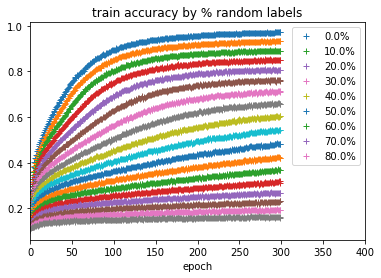

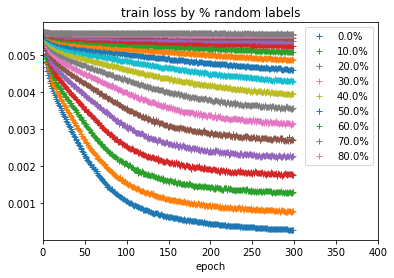

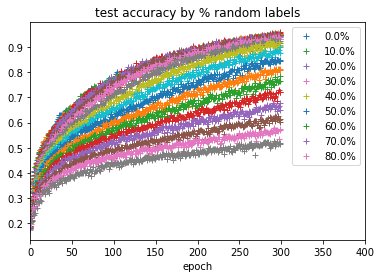

In [5]:
import matplotlib.pyplot as plt

train_acc, train_loss, test_acc = [], [], []

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

X = np.arange(0, total_epochs, 1)
for i in range(18):
    train_acc, train_loss, test_acc = MLP.load_metrics(MLP._save_dir(i, 300, "random_labels"))
    ax1.plot(X, train_acc, '+',  label=f"{100 * i / 20}%" if i in range(0, 18, 2) else "_")
    ax2.plot(X, train_loss, '+', label=f"{100 * i / 20}%" if i in range(0, 18, 2) else "_")
    ax3.plot(X, test_acc, '+',   label=f"{100 * i / 20}%" if i in range(0, 18, 2) else "_")
    
ax1.legend()
ax2.legend()
ax3.legend()

ax1.set(xlabel="epoch", xlim=(0,400), title="train accuracy by % random labels")
ax2.set(xlabel="epoch", xlim=(0,400), title="train loss by % random labels")
ax3.set(xlabel="epoch", xlim=(0,400), title="test accuracy by % random labels")

From the top plot, we can see that as the % of random labels increases, training accuracy increases, and it also takes longer to converge. Something very similar happens in the second plot, with the training loss being barely distinguishable from guessing at about 75% randomization. The third plot, however, shows something different - the test accuracy *doesn't* decline until about 30% - 40% randomization. This means we should expect there to be some kind of a "phase transition" happening in the weight matrices at about that point. Let's take a closer look at those accuracy curves.

[Text(0.5, 0, 'epoch'),
 (120.0, 350.0),
 (0.85, 0.95),
 Text(0.5, 1.0, 'test accuracy by % random labels')]

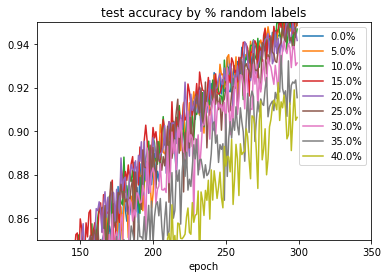

In [6]:
test_acc = []
fig3, ax3 = plt.subplots()

X = np.arange(0, total_epochs, 1)
for i in range(0, 9):
    train_acc, train_loss, test_acc = MLP.load_metrics(MLP._save_dir(i, 300, "random_labels"))
    ax3.plot(X, test_acc,   label=f"{100 * i / 20}%")
    
ax3.legend()
ax3.set(xlabel="epoch", xlim=(120,350), ylim=(0.85, 0.95), title="test accuracy by % random labels")

INFO:weightwatcher:

python      version 3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0]
numpy       version 1.20.3
tensforflow version 2.10.0
keras       version 2.10.0
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': False, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'detX': False, 'mp_fit': False, 'min_evals': 50, 'max_evals': 10000, 'tolerance': 1e-06, 'glorot_fit': False, 'layers': [], 'layer_ids_start': 0}
INFO:weightwatcher:Saving all images to ww-img


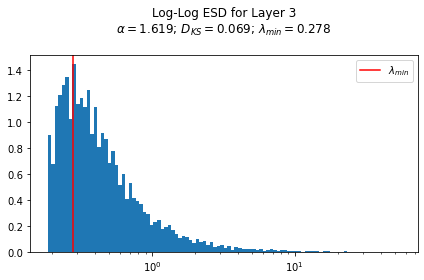

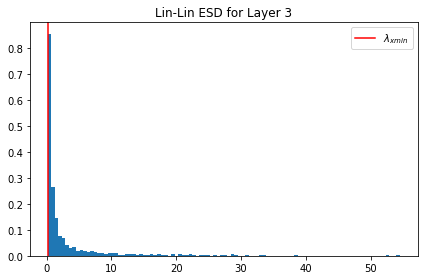

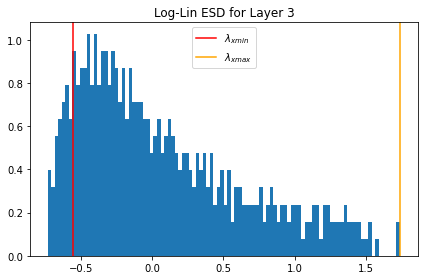

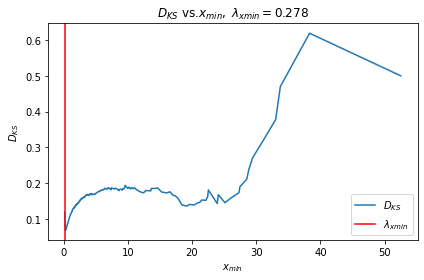

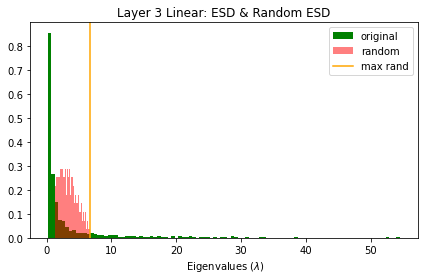

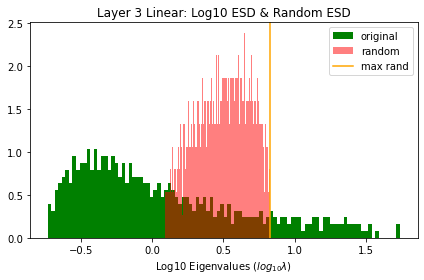

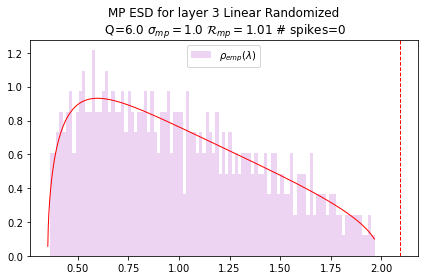

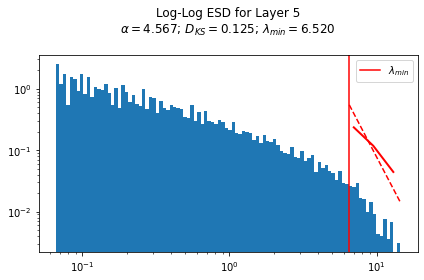

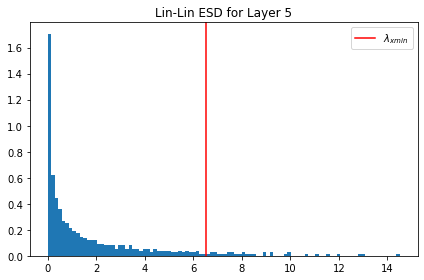

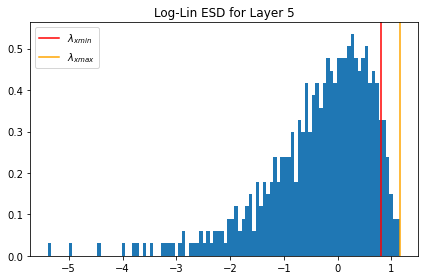

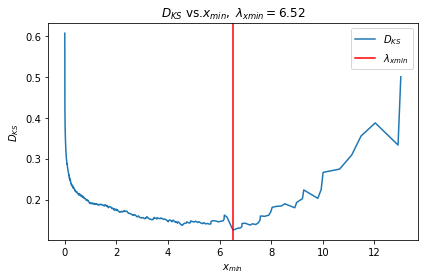

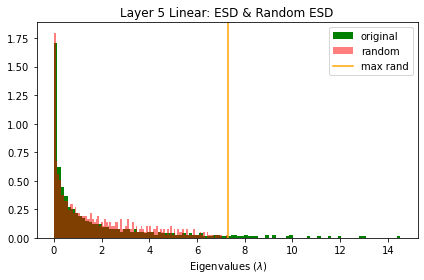

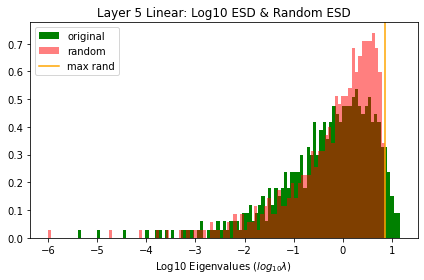

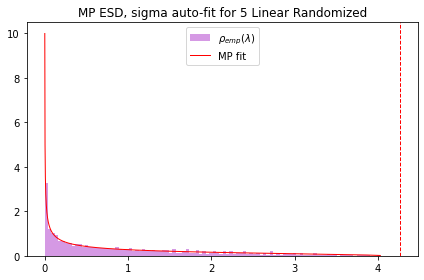

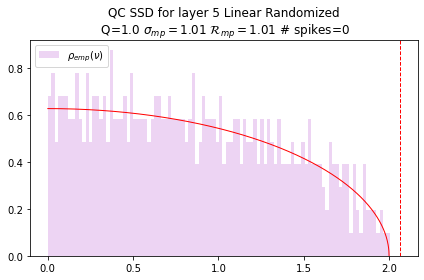

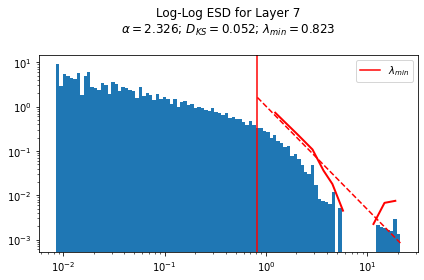

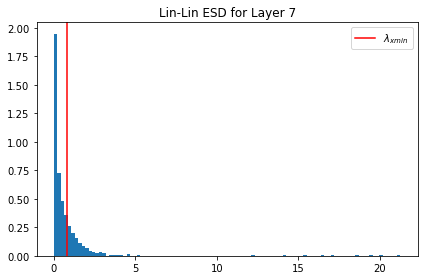

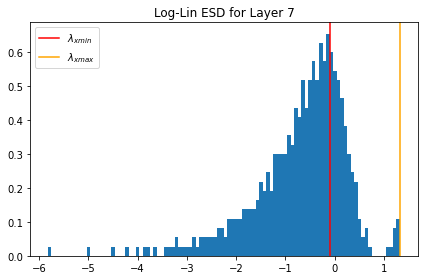

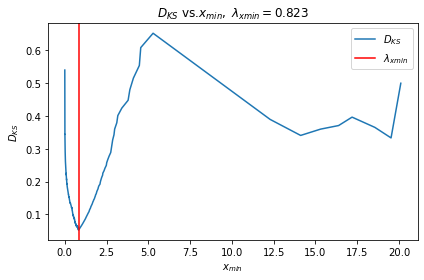

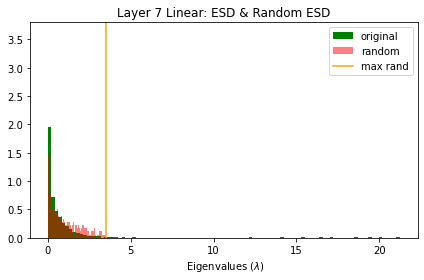

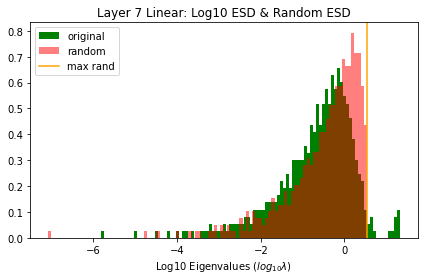

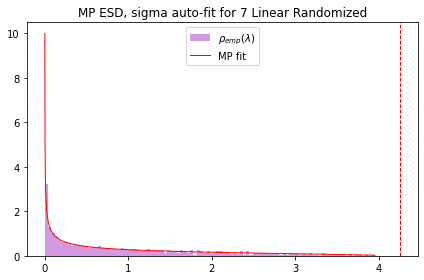

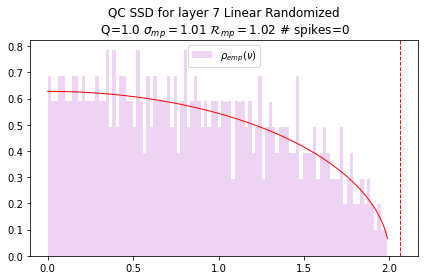

,layer_id,name,D,Lambda,M,N,alpha,alpha_weighted,best_fit,entropy,...,rank_loss,rf,sigma,spectral_norm,stable_rank,sv_max,warning,weak_rank_loss,xmax,xmin
0,3,Linear,0.069093,-1.0,512.0,3072.0,1.619350,2.812388,power_law,0.833920,...,0.0,1.0,0.028846,54.543015,31.783022,7.385324,over-trained,0.0,54.543015,0.277971
0,5,Linear,0.125258,-1.0,512.0,512.0,4.567357,5.306803,lognormal,0.881212,...,0.0,1.0,0.611797,14.517706,63.751761,3.810211,success,0.0,14.517706,6.520046
0,7,Linear,0.052157,-1.0,512.0,512.0,2.325880,3.087009,power_law,0.809684,...,0.0,1.0,0.114114,21.244337,21.365194,4.609158,success,0.0,21.244337,0.822703


<Figure size 432x288 with 0 Axes>

In [7]:
m = MLP()
m.load(0, 300, "random_labels")

from weightwatcher import WeightWatcher
watcher = WeightWatcher(model=m)
watcher.analyze(plot=True, randomize=True)

Here we can see several things: the alpha_weighted numbers are all in the 2 - 4 range. The Red and Green plots show that these matrices are *not* behaving like elementwise i.i.d. random matrices. 

Next, let's look at what happens at 35% random labels.

INFO:weightwatcher:

python      version 3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0]
numpy       version 1.20.3
tensforflow version 2.10.0
keras       version 2.10.0
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': False, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'detX': False, 'mp_fit': False, 'min_evals': 50, 'max_evals': 10000, 'tolerance': 1e-06, 'glorot_fit': False, 'layers': [], 'layer_ids_start': 0}
INFO:weightwatcher:Saving all images to ww-img


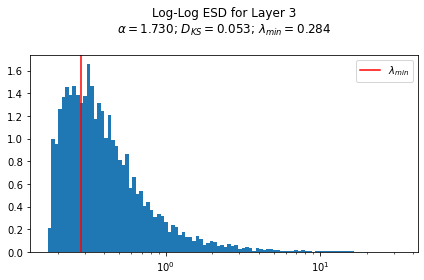

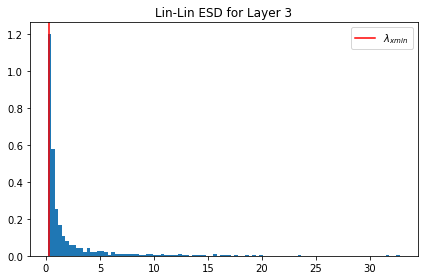

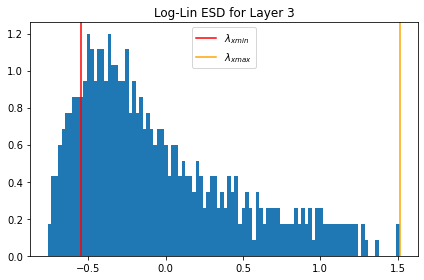

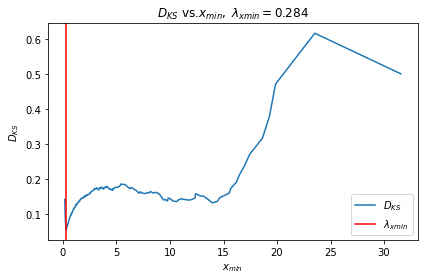

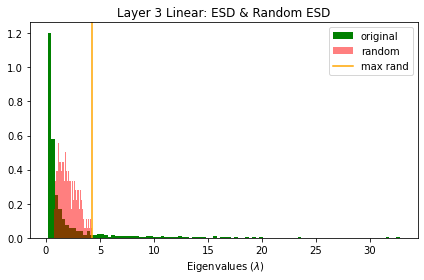

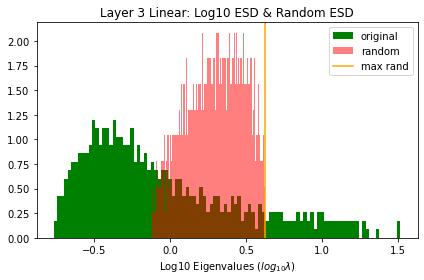

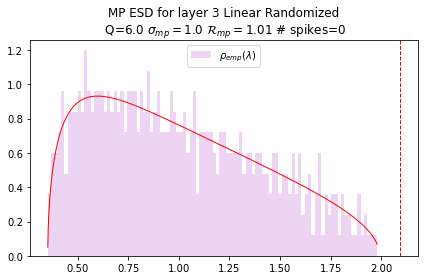

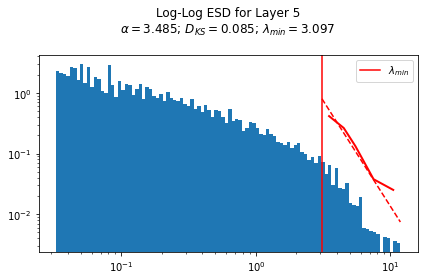

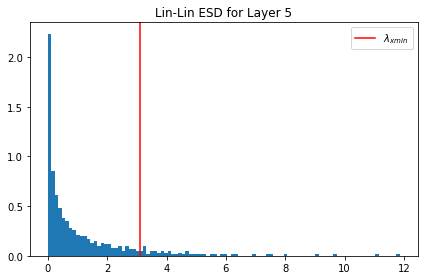

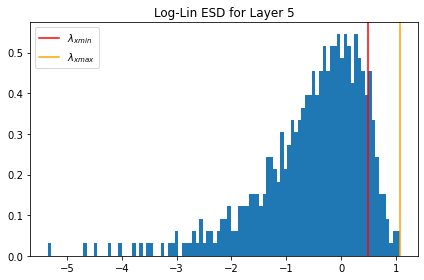

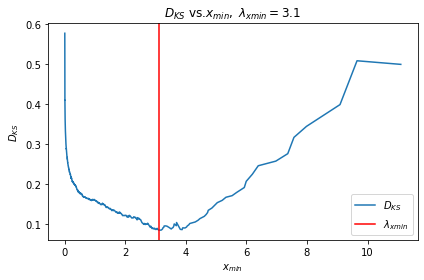

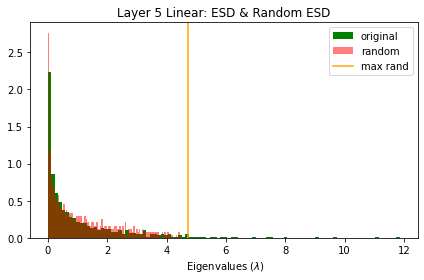

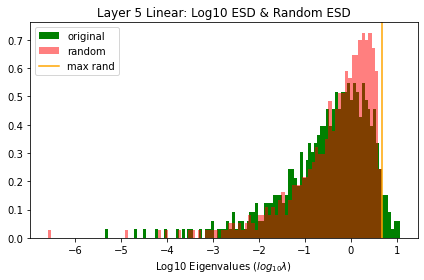

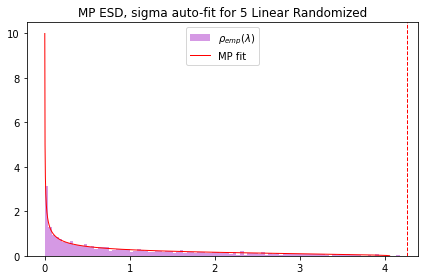

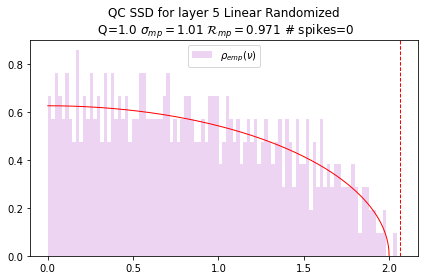

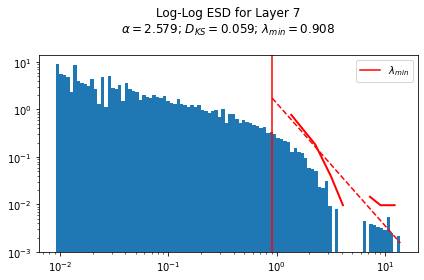

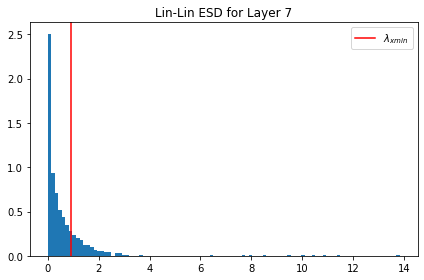

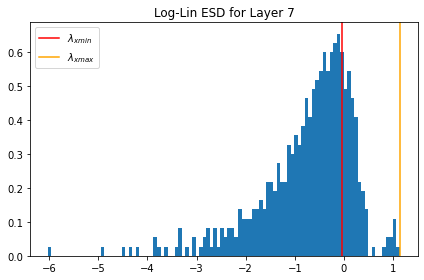

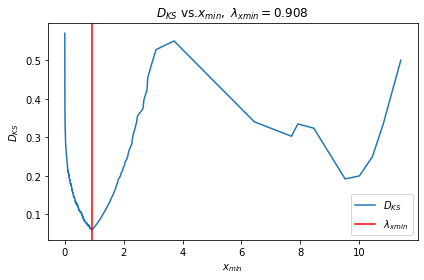

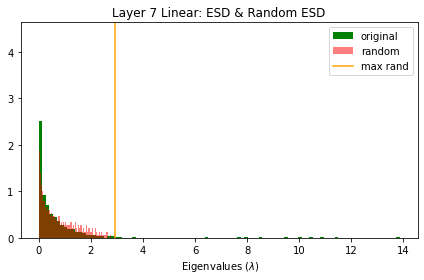

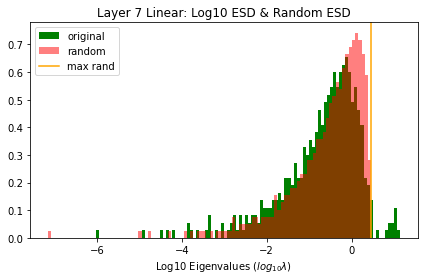

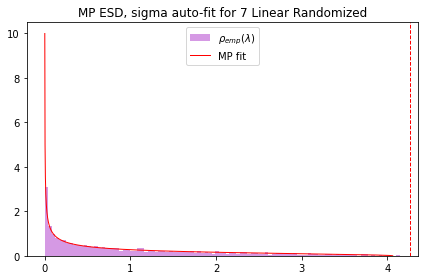

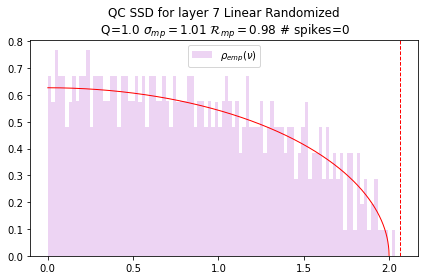

,layer_id,name,D,Lambda,M,N,alpha,alpha_weighted,best_fit,entropy,...,rank_loss,rf,sigma,spectral_norm,stable_rank,sv_max,warning,weak_rank_loss,xmax,xmin
0,3,Linear,0.053215,-1.0,512.0,3072.0,1.729995,2.621955,power_law,0.854900,...,0.0,1.0,0.034683,32.778218,33.560192,5.725226,over-trained,0.0,32.778218,0.283514
0,5,Linear,0.084621,-1.0,512.0,512.0,3.484762,3.743950,power_law,0.879829,...,0.0,1.0,0.341308,11.867996,48.825448,3.444996,success,0.0,11.867996,3.097450
0,7,Linear,0.059336,-1.0,512.0,512.0,2.578890,2.943828,power_law,0.850458,...,0.0,1.0,0.147877,13.851917,26.039721,3.721816,success,1.0,13.851917,0.908064


<Figure size 432x288 with 0 Axes>

In [7]:
m = MLP()
# 7 / 20 = 35%
m.load(7, 300, "random_labels")

from weightwatcher import WeightWatcher
watcher = WeightWatcher(model=m)
watcher.analyze(plot=True, randomize=True)

Here we can see the correlation trap in layers 5 and 7, and weak rank collapse in layer 3, but the alpha values are still in the right range, and there is some difference between the red and green plots. Now lets' look at when the randomization is at 45%.

INFO:weightwatcher:

python      version 3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0]
numpy       version 1.20.3
tensforflow version 2.10.0
keras       version 2.10.0
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': False, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'detX': False, 'mp_fit': False, 'min_evals': 50, 'max_evals': 10000, 'tolerance': 1e-06, 'glorot_fit': False, 'layers': [], 'layer_ids_start': 0}
INFO:weightwatcher:Saving all images to ww-img


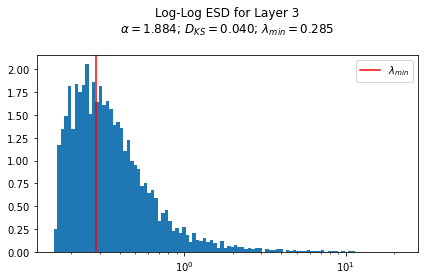

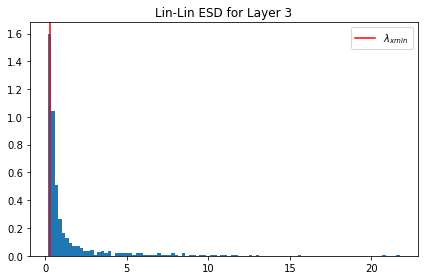

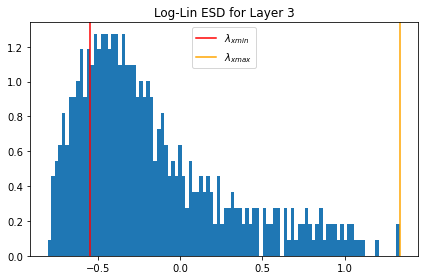

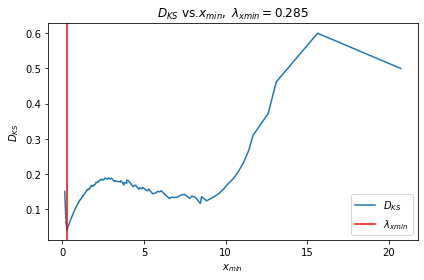

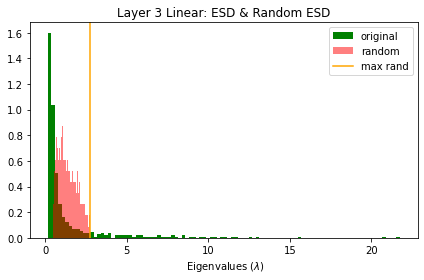

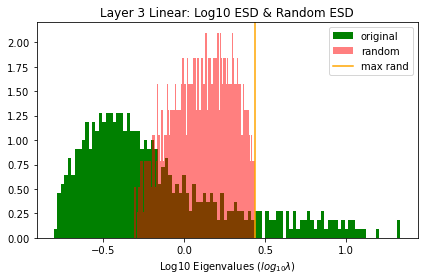

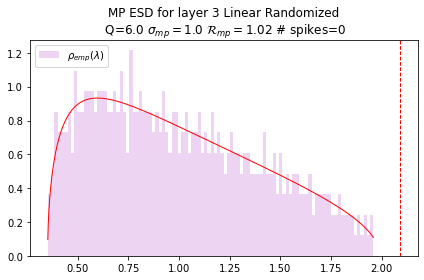

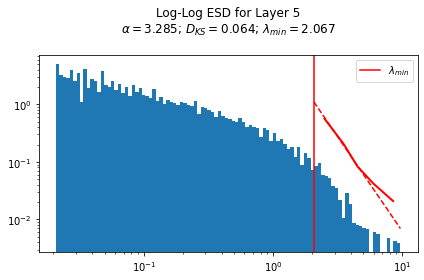

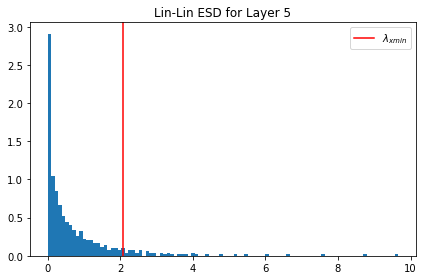

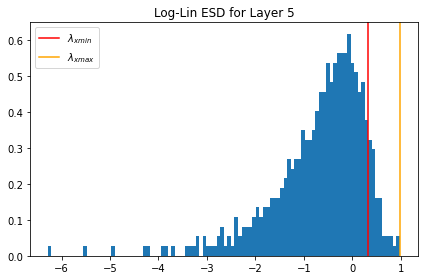

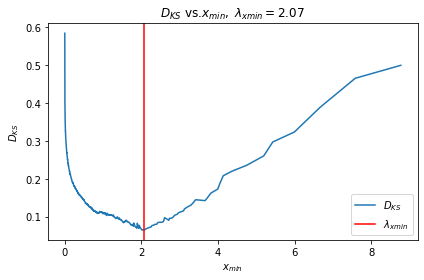

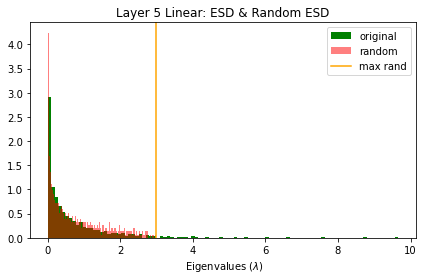

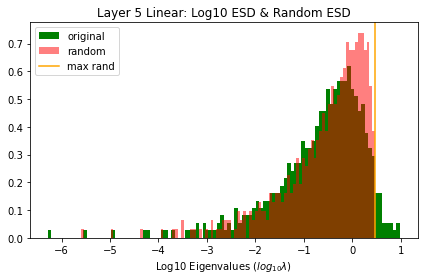

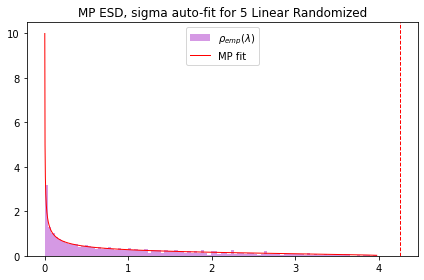

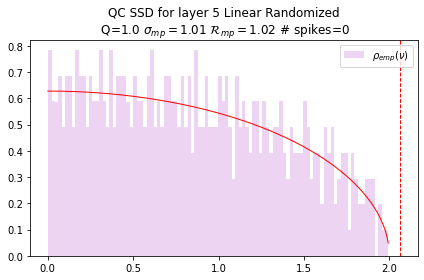

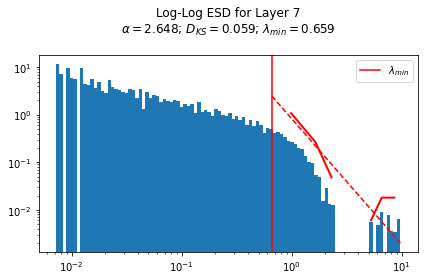

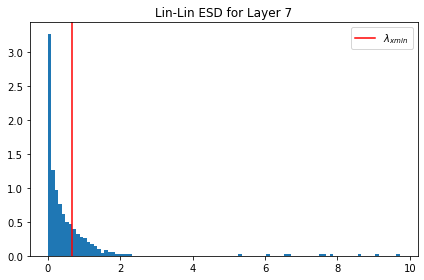

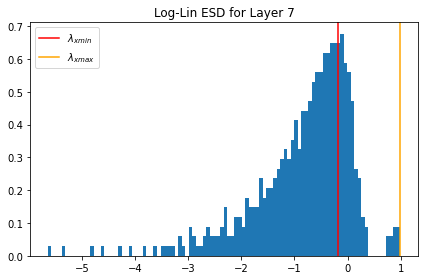

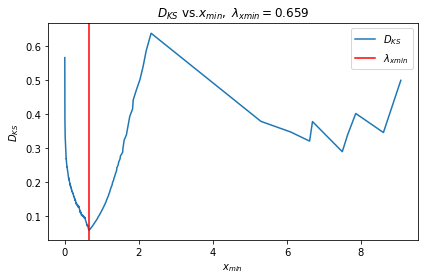

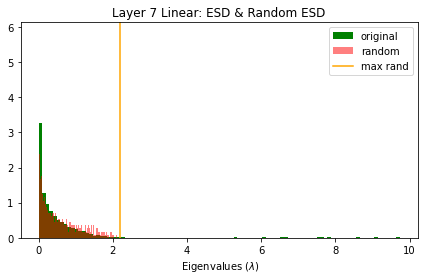

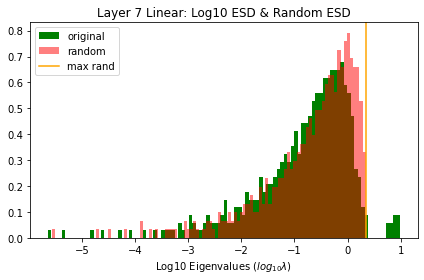

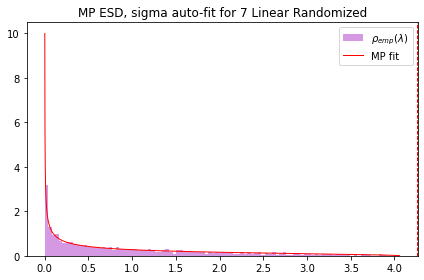

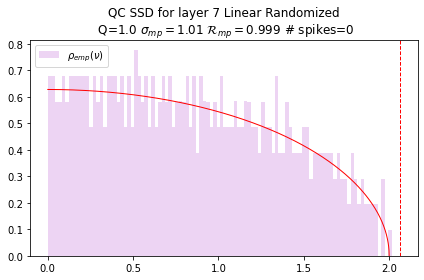

,layer_id,name,D,Lambda,M,N,alpha,alpha_weighted,best_fit,entropy,...,rank_loss,rf,sigma,spectral_norm,stable_rank,sv_max,warning,weak_rank_loss,xmax,xmin
0,3,Linear,0.040262,-1.0,512.0,3072.0,1.884007,2.520007,power_law,0.866644,...,0.0,1.0,0.043658,21.755962,32.851737,4.664329,over-trained,0.0,21.755962,0.284683
0,5,Linear,0.064125,-1.0,512.0,512.0,3.284731,3.235627,power_law,0.878588,...,0.0,1.0,0.329773,9.661640,39.863385,3.108318,success,1.0,9.661640,2.067109
0,7,Linear,0.058784,-1.0,512.0,512.0,2.648167,2.616630,power_law,0.855170,...,0.0,1.0,0.146830,9.729516,28.583011,3.119217,success,0.0,9.729516,0.658911


<Figure size 432x288 with 0 Axes>

In [8]:
m = MLP()
# 9 / 20 = 45%
m.load(9, 260, "random_labels")

from weightwatcher import WeightWatcher
watcher = WeightWatcher(model=m)
watcher.analyze(plot=True, randomize=True)


Next let's look at the weights for 70% randomization...

INFO:weightwatcher:

python      version 3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0]
numpy       version 1.20.3
tensforflow version 2.10.0
keras       version 2.10.0
INFO:weightwatcher:Saving all images to ww-img
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'ww-img', 'savefig': 'ww-img', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': False, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'fit': 'power_law', 'sparsify': True, 'detX': False, 'mp_fit': False, 'min_evals': 50, 'max_evals': 10000, 'tolerance': 1e-06, 'glorot_fit': False, 'layers': [], 'layer_ids_start': 0}
INFO:weightwatcher:Saving all images to ww-img


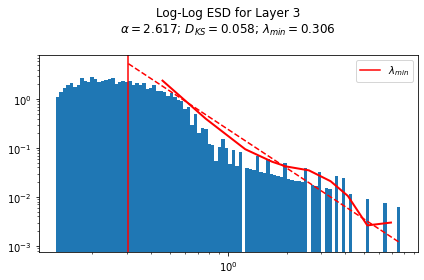

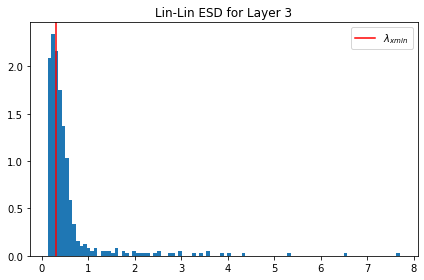

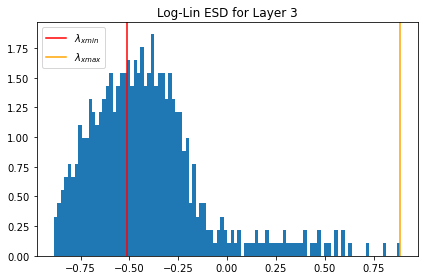

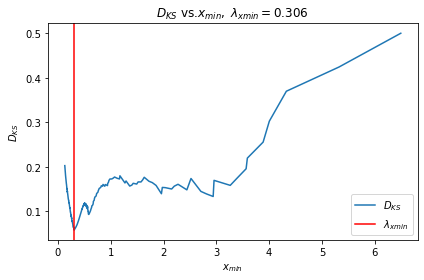

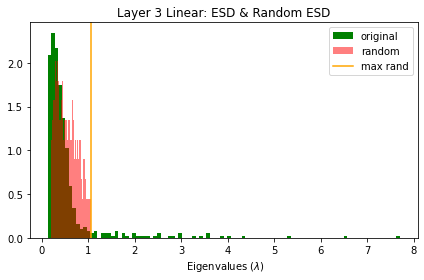

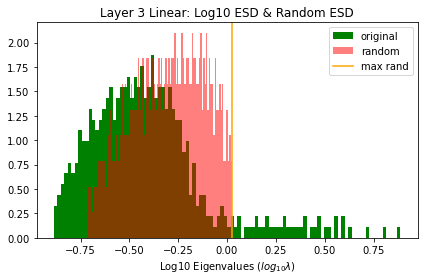

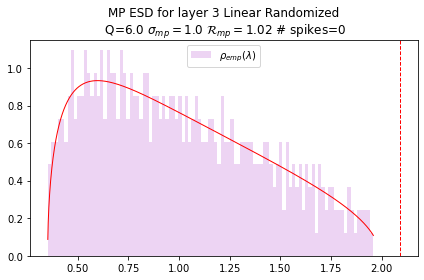

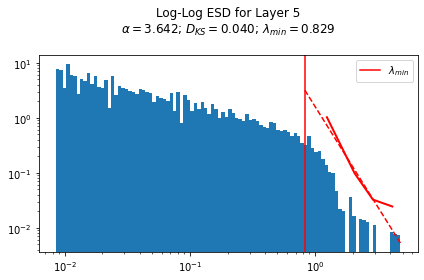

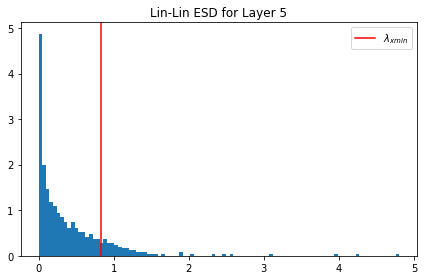

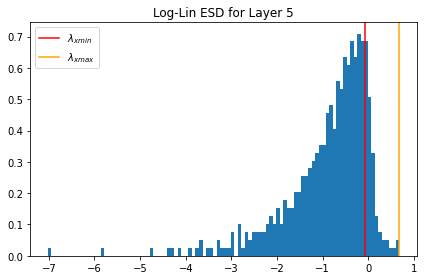

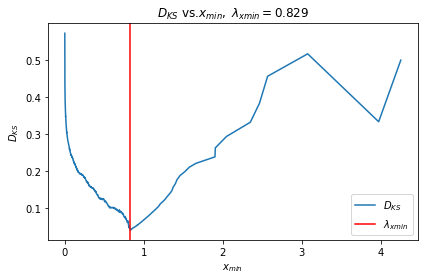

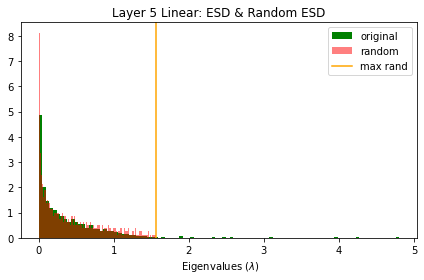

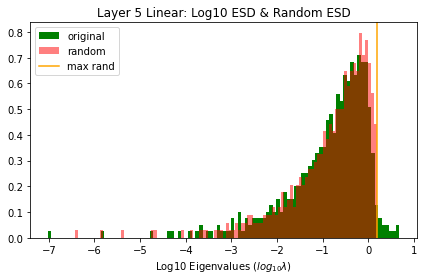

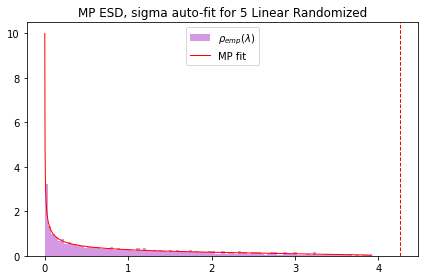

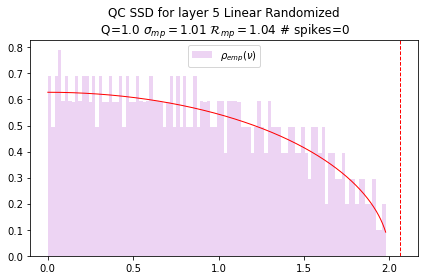

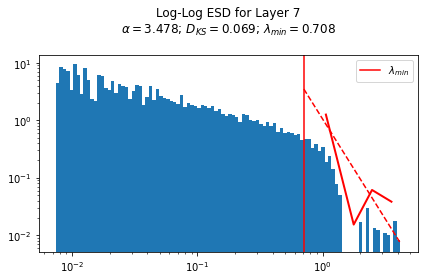

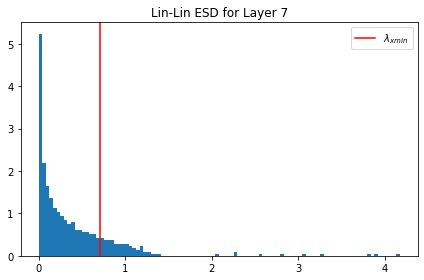

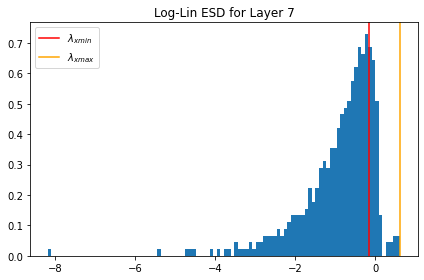

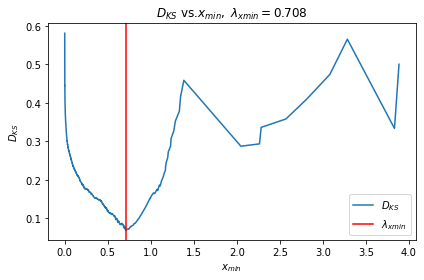

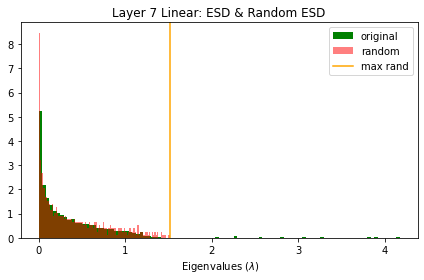

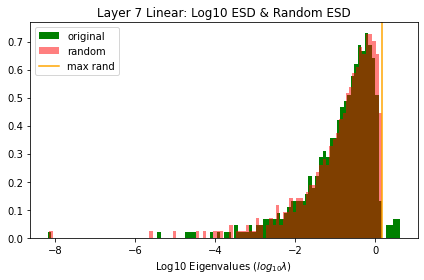

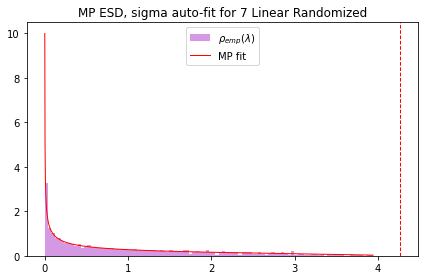

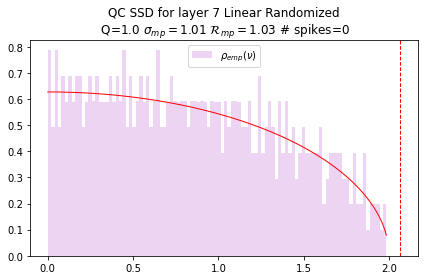

,layer_id,name,D,Lambda,M,N,alpha,alpha_weighted,best_fit,entropy,...,rank_loss,rf,sigma,spectral_norm,stable_rank,sv_max,warning,weak_rank_loss,xmax,xmin
0,3,Linear,0.057547,-1.0,512.0,3072.0,2.616587,2.319914,power_law,0.929004,...,0.0,1.0,0.091521,7.702260,36.034771,2.775295,success,0.0,7.702260,0.306125
0,5,Linear,0.040028,-1.0,512.0,512.0,3.642376,2.482450,power_law,0.899905,...,0.0,1.0,0.307170,4.803381,42.504464,2.191662,success,1.0,4.803381,0.828768
0,7,Linear,0.068950,-1.0,512.0,512.0,3.478433,2.157423,power_law,0.900142,...,0.0,1.0,0.258394,4.170888,47.389613,2.042275,success,1.0,4.170888,0.707893


<Figure size 432x288 with 0 Axes>

In [9]:
m = MLP()
# 14 / 20 = 70%
m.load(14, 280, "random_labels")

from weightwatcher import WeightWatcher
watcher = WeightWatcher(model=m)
watcher.analyze(plot=True, randomize=True)

In [ ]:
The pattern has progressed further 